# Check spinup day

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import multiprocessing
from multiprocessing import Pool
import os
import matplotlib.cm as cm
from scipy.interpolate import interp1d
from abc import ABC, abstractclassmethod
from EOF import EOF
from scipy.fftpack import fft,ifft,fftfreq
import datetime 

In [2]:
class Dycore:
    def __init__(self, file):
        self.ds = h5py.File(file, "r")
        self.Rd = 287
        self.cp = 1004
        self.g  = 9.81
        self.H  = 6800
        self.a  = 6.37122e6
        self.u  = self.getVar("grid_u_c_xyzt")
        self.v  = self.getVar("grid_v_c_xyzt")
        self.t  = self.getVar("grid_t_c_xyzt")
        self.ps = self.getVar("grid_ps_xyzt")
        self.p  = self.getVar("grid_p_full_xyzt")
        self.p_half  = self.getVar("grid_p_half_xyzt")

        self.qv   = self.getVar("grid_tracers_c_xyz1t")
        self.qv_n = self.getVar("grid_tracers_n_xyz1t")
        self.qv_p = self.getVar("grid_tracers_p_xyz1t")
        # self.grid_t_eq_ref_xyzt = self.getVar("grid_t_eq_ref_xyzt")
        # self.unsaturated = self.getVar("unsaturated_n_xyzt")
        self.add_water   = self.getVar("add_water_xyzt")
        self.rho = self.getVar("rho_xyzt")
        
        self.qv_diff = self.getVar("grid_tracers_diff_xyz1t")
        self.omega   = self.getVar("grid_w_full_xyzt")
        self.z       = self.getVar("grid_z_full_xyzt")
        self.factor1 = self.getVar("factor1_xyzt")
        self.factor2 = self.getVar("factor2_xyzt")
        self.factor3 = self.getVar("factor3_xyzt")
        self.factor4 = self.getVar("factor4_xyzt")

        self.K_E = self.getVar("K_E_xyzt")
        self.pqpz = self.getVar("pqpz_xyzt")
        
        # self.qv_global_intergral = self.getVar("qv_global_intergral_xyzt")
        self.theta = self.t * (self.ps / self.p)**(self.Rd/self.cp)
        
        self.Uzm   = np.nanmean(self.u, axis=3)
        self.Vzm   = np.nanmean(self.v, axis=3)
        self.THzm  = np.nanmean(self.theta, axis=3)
        self.Pzm   = np.nanmean(self.p, axis=3)
        self.Tzm   = np.nanmean(self.t, axis=3)
        
        ### anamoly
        self.Vzmtm  = np.nanmean(self.Vzm, axis=0)
        self.Uzmtm  = np.nanmean(self.Uzm, axis=0)
        self.THzmtm = np.nanmean(self.THzm, axis=0)
        self.Pzmtm  = np.nanmean(self.Pzm, axis=0)
        self.Tzmtm  = np.nanmean(self.Tzm, axis=0)

        self.Vza     = np.zeros(self.u.shape)
        self.Uza     = np.zeros(self.u.shape)
        self.THETAza = np.zeros(self.u.shape)
        self.Pza     = np.zeros(self.u.shape)
        self.Tza     = np.zeros(self.t.shape)

        for i in range(0,128):
            self.Vza[:,:,:,i]     = self.v[:,:,:,i] - self.Vzm
            self.Uza[:,:,:,i]     = self.u[:,:,:,i] - self.Uzm
            self.THETAza[:,:,:,i] = self.theta[:,:,:,i] - self.THzm
            self.Pza[:,:,:,i]     = self.p[:,:,:,i] - self.Pzm
            self.Tza[:,:,:,i]     = self.t[:,:,:,i] - self.Tzm
        
        ### the variables for plot
        self.sigma_mean           = np.nanmean(self.p/self.ps, axis=(0,3))
        self.sigma_onlyz          = np.nanmean(self.sigma_mean, axis=1)
        self.y                    = np.linspace(-90,90,64)
        self.yy, self.sigma_mean2 = np.meshgrid(self.y,self.sigma_onlyz)
        
        ### cooridate
        self.x  = np.linspace(-180,180,128)
        self.y  = np.linspace(-90,90,64)
        self.xd = np.deg2rad(self.x)
        self.yd = np.deg2rad(self.y)
        
        # WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
        self.cy     = np.cos(self.yd)
        self.cy[0]  = np.nan
        self.cy[-1] = np.nan

    def getVar(self, var):
        # self.u  = self.ds["grid_u_c_xyzt"]
        return np.asarray(self.ds[var])
    
    def cal_KE(self):
        self.KE = (self.u**2 + self.v**2)
        self.KE_mean = np.nanmean(self.KE, axis=(1,3))
        return self.KE_mean
    
    def cal_pre(self):
        self.Prec = np.zeros(self.u.shape)
        self.time_start = 1
        for i in range(1,20-1):
            self.Prec[self.time_start:,i,:,:] = 1/self.g * self.qv_diff[self.time_start:,i,:,:] * (self.p[self.time_start:,i+1,:,:] - self.p[self.time_start:,i-1,:,:])/2
        # self.Prec[:, 0,:,:] = 1/self.g * self.qv_diff[:, 0,:,:] * (self.p[:, 1,:,:] - self.p[:, 0,:,:])/2
        # self.Prec[:,-1,:,:] = 1/self.g * self.qv_diff[:,-1,:,:] * (self.p[:,-1,:,:] - self.p[:,-2,:,:])/2
        
        self.Prec_mean = np.nansum(self.Prec, axis=(1))
        self.Prec_mean2 = np.nanmean(self.Prec_mean, axis=(2))
        
        return self.Prec_mean2
    
    def cal_t(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_t_last(self):
        print(np.nanmax(self.t), np.nanmin(self.t))
        self.t_mean = np.nanmean(self.t[-100:,:,:,:], axis=(1,3))
        return self.t_mean
    
    def cal_diff(self):
        
        return np.nanmean(self.factor3, axis=(1,3))

311.53576375199503 185.7638491683804


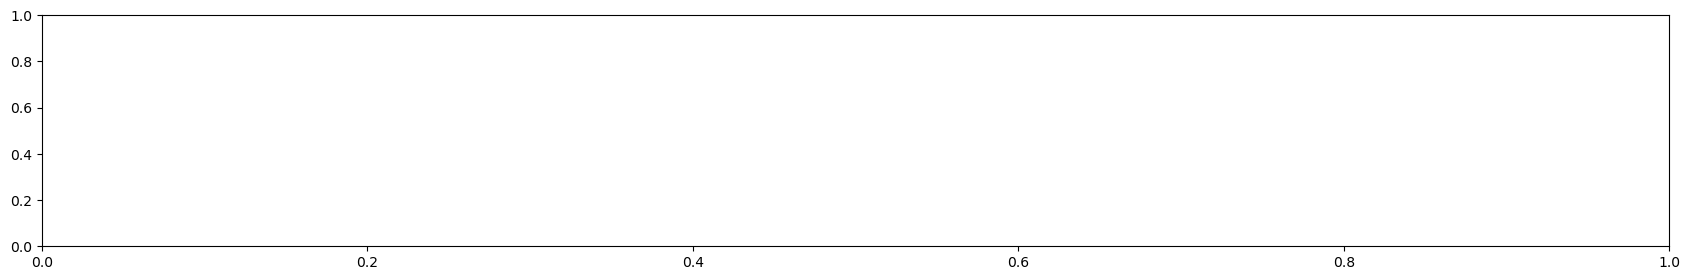

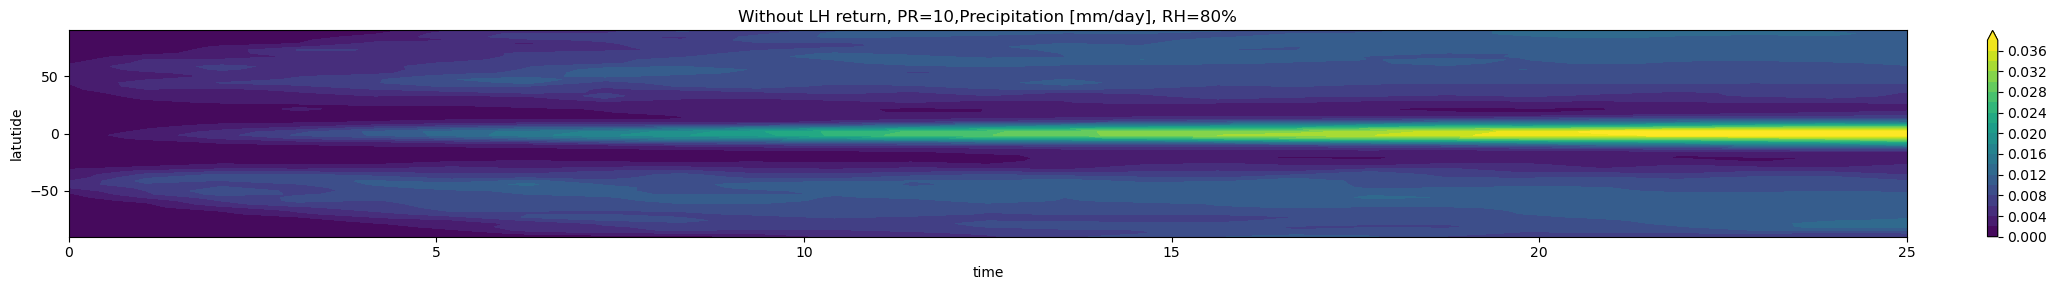

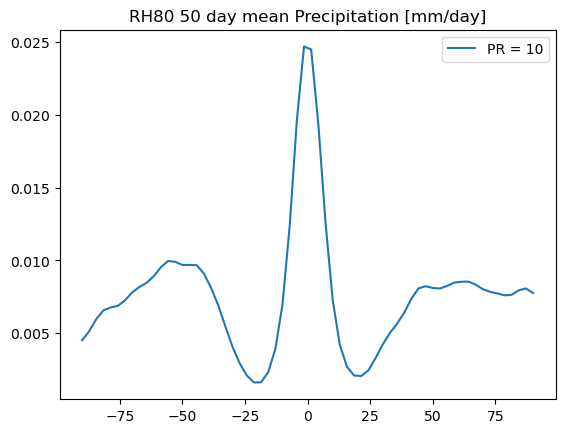

In [4]:
file = "1203_25day_factor123_final.dat"
time = np.linspace(0,25,25)
y    = np.linspace(-90,90,64)

yy, tt = np.meshgrid(y,time)
a = int(0)
fig = plt.figure(figsize=(21,3))
for pr in range(10,20,10):
    # file   = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "t_init_RH80_PR10_1600day_test_all.dat"
    # file = "test_final.dat"
    dycore = Dycore(file)
    # get_KE = dycore.cal_KE()   
    Prec   = dycore.cal_diff()

    t_mean = dycore.cal_t()
    # t_mean2 = dycore.cal_t_last()
    
    
    # CS = plt.contourf(tt, yy, get_KE,levels=21, extend="both")
    
    CS = plt.contourf(tt, yy, Prec[:,:] * int(pr),levels=21, extend="max")
        
    # CS = plt.contourf(tt, yy, t_mean, levels=21, extend="both")
    
    
    plt.colorbar(CS, orientation='vertical',fraction=0.046, pad=0.04)
    # ax[a].set_title(f"Kinetic Energy [kJ/kg], PR={pr}")
    
    plt.title(f"Without LH return, PR={pr},Precipitation [mm/day], RH=80%")
    # ax[a].set_title(f"T [K], PR={pr}")
    
    plt.xlabel("time")
    plt.ylabel("latutide")
    a += 1
    ### test
    
plt.tight_layout()
# plt.savefig("Without LH return precipitation.png", dpi=300., bbox_inches='tight')
plt.show()
###############################################################################
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

plt.figure(dpi=100.)
plt.title("RH80 50 day mean Precipitation [mm/day]")

for pr in range(10,20,10):
    # file  = f"1600day_HS_front_RH50_PR{pr}_PRRELAX86400_with_w_all.dat"# f"HS_front_RH50_PR10_PRRELAX86400_with_w_all.dat" # ./outputs/withprecip/
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    dycore = Dycore(file)
    Prec   = dycore.cal_diff()
    Prec_mean  = np.nanmean(Prec[:,:], axis=0)
    plt.plot(y, Prec_mean * int(pr), label=f"PR = {pr}")
plt.legend()
plt.show()


# Cal qv

In [ ]:
dycore = Dycore(file)
v_o = dycore.v
w_o = -dycore.omega
yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2
u = dycore.u
v = dycore.v

p = dycore.p
ps = dycore.ps
qv = dycore.qv
qv_diff = dycore.qv_diff
t = dycore.t

Lv = 2.5 * 10**6
Rv = 461
# grid_t_eq_ref = dycore.grid_t_eq_ref_xyzt
# grid_tracers_t_eq_ref = (0.622 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / grid_t_eq_ref)) )) / (p - 0.378 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / grid_t_eq_ref)) )) ######### 10/30 cc equation should use grid_t

w = np.nanmean(w_o[:], axis=(0,3))
v = np.nanmean(v_o[:], axis=(0,3))

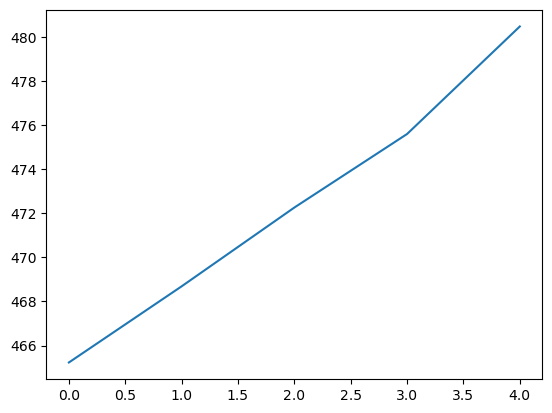

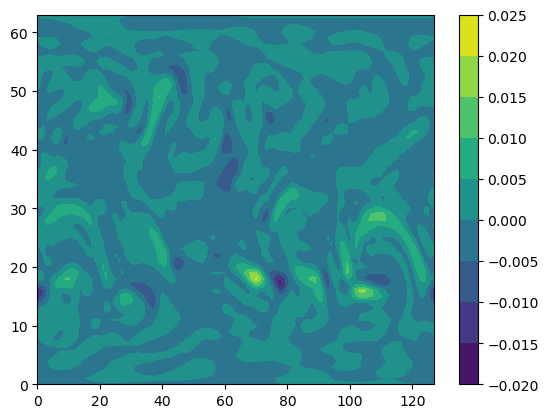

In [ ]:
qv_sum = np.nansum(qv, axis=(1,2,3))
plt.figure()
plt.plot(qv_sum)
plt.show()

qv_p = qv[0,20-1,:,:]
qv_n = qv[1,20-1,:,:]

plt.figure()
CS = plt.contourf(qv_p - qv_n)
plt.colorbar(CS)
plt.show()

### Cal qv, qv_diff, and meridional circulation, add water

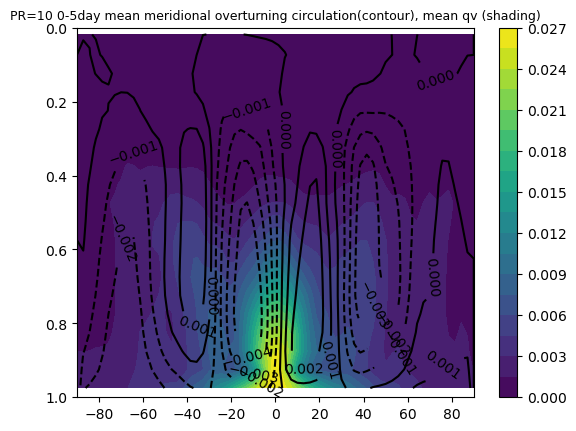

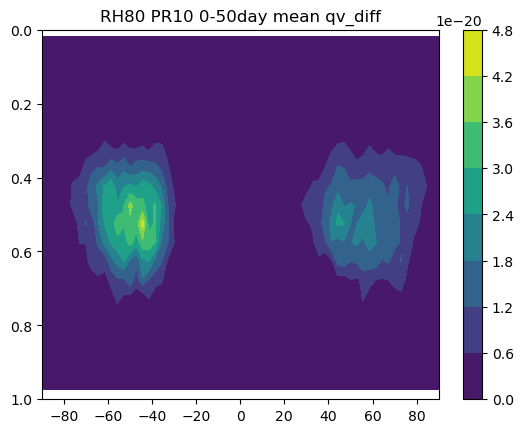

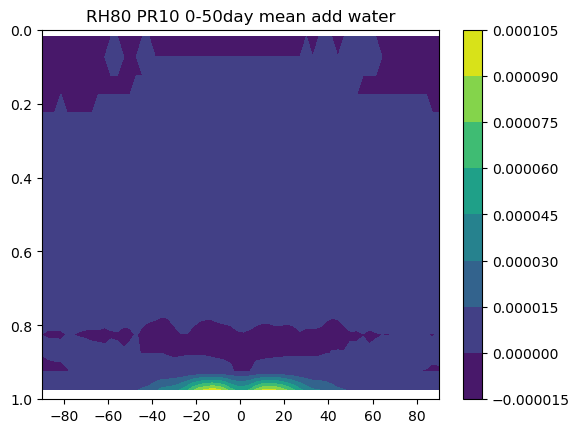

In [ ]:
### cooridate
x  = np.linspace(-180,180,128)
y  = np.linspace(-90,90,64)
xd = np.deg2rad(x)
yd = np.deg2rad(y)

# WARNING: cos(-90) would be zero, doing this preventing it from divide by zero.
cy     = np.cos(yd)
cy[0]  = np.nan
cy[-1] = np.nan

rho_0     = np.zeros((20,64))
rho_0_all = np.zeros(u.shape)
for i in range(0,20):
    rho_0[i,:] =   np.nanmean(p, axis=(0,3))[i,:] / np.nanmean(ps, axis=(0,3))[0,:] # np.exp(-Z[i,:]/H) 
    rho_0_all[:,i,:,:] = p[:,i,:,:] / ps[:,0,:,:]  
# phi
a = 6.37122e6
lat   = np.linspace(-90, 90, 64)
phi = np.broadcast_to(np.deg2rad(lat).reshape(1,64),(20,64)) # Get latitude in radians
cphi  = np.cos(phi) 
acphi = a * cphi

psi_w1 = np.zeros((20,64))
psi_w2 = np.zeros((20,64))

psi_w1[:,0] = 0
for ilat in range(1,64-1):
    dlat = phi[:,ilat] - phi[:,ilat-1]       
    psi_w1[:,ilat] =  psi_w1[:,ilat-1] + (dlat * (w)[:,ilat])
    # print(psi_w1[:,ilat])

psi_w2[:,64-1] = 0    
for jlat in range(1,64-1):
    ilat = 64 - 1 - jlat
    dlat = phi[:,ilat] - phi[:,ilat+1]           
    psi_w2[:,ilat] =  psi_w2[:,ilat+1] + (dlat * (w)[:,ilat])

psi_w = 0.5*(psi_w1 + psi_w2)
###
qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))
###


for i in range(10,20,10):
    pr = i
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "day20_hope_test_all.dat"
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_mean = np.nanmean(qv[-1:,:,:,:], axis=(0,3))

    plt.figure(dpi=100.)
    CS = plt.contourf(yy, sigma_mean2, qv_mean, levels=21)

    CT = plt.contour(yy, sigma_mean2, psi_w, colors='k')

    plt.colorbar(CS)

    plt.clabel(CT)

    plt.ylim([1,0])
    plt.title(f"PR={pr} 0-5day mean meridional overturning circulation(contour), mean qv (shading)", fontsize=9)
    plt.show()
##################################################################################################
for i in range(10,20,10):
    pr = i
    # file = f"PR{pr}_200day_test_ice_all.dat"
    # file = "300day_RH80_PR10_test_vertical_advection_revised_all.dat"
    # file = "day10_hope_test_all.dat"
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv_diff = dycore.qv_diff

    plt.figure(dpi=100.)
    qv_diff_mean = np.nanmean(qv_diff[:,:,:,:], axis=(0,3))
    # qv_diff_mean = np.nanmean(qv_diff[-100:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, qv_diff_mean)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-50day mean qv_diff")

    plt.ylim([1,0])
    plt.show()
##################################################################################################

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    add_water = dycore.add_water

    plt.figure(dpi=100.)
    add_water_mean = np.nanmean(add_water[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, add_water_mean)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-50day mean add water")

    plt.ylim([1,0])
    plt.show()



### factor 1 and 2, K_E, qv, pqpz

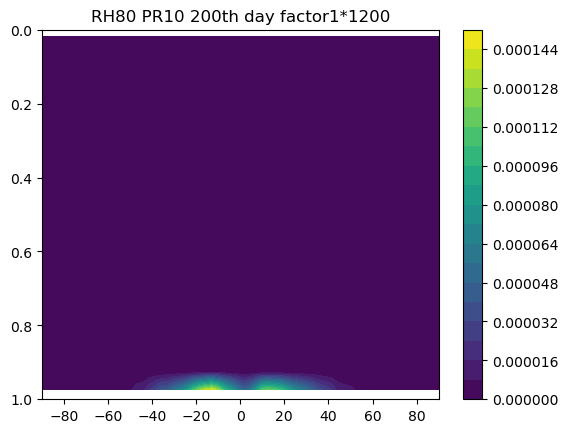

<ipython-input-5-05c383fc07e2>:32: UserWarning: The following kwargs were not used by contour: 'color'
  plt.contour(yy, sigma_mean2, factor2_mean, [0,0.00001], color='k')


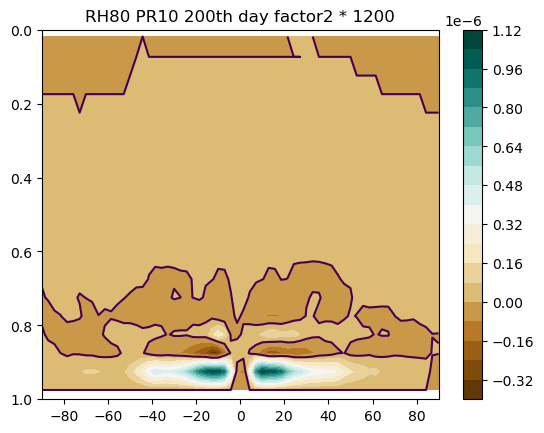

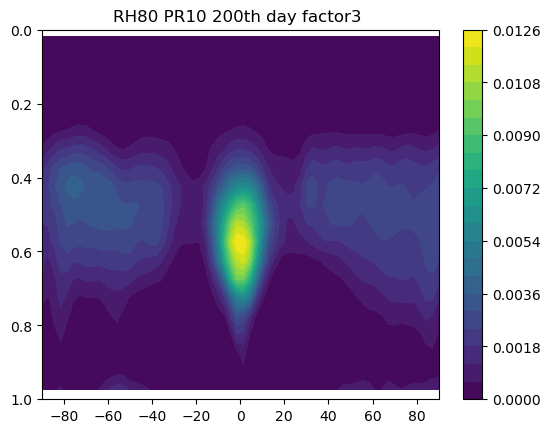

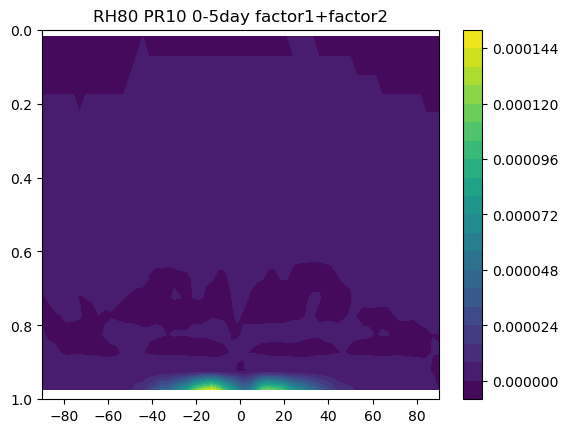

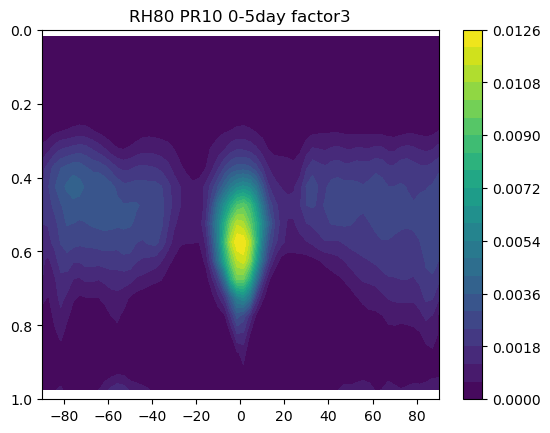

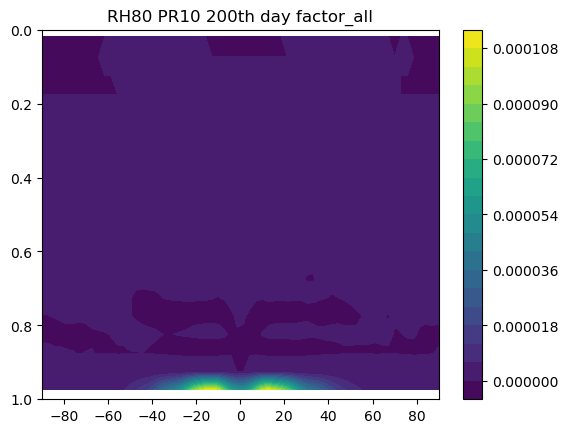

In [5]:
day_ini = -2
day_final = -1

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor1 = dycore.factor1

    plt.figure(dpi=100.)
    factor1_mean = np.nanmean(factor1[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor1_mean , levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day factor1*1200")

    plt.ylim([1,0])
    plt.show()
#############################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor2 = dycore.factor2

    plt.figure(dpi=100.)
    factor2_mean = np.nanmean(factor2[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor2_mean , levels=21, cmap="BrBG")
    plt.contour(yy, sigma_mean2, factor2_mean, [0,0.00001], color='k')
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day factor2 * 1200")

    plt.ylim([1,0])
    plt.show()
#################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor3 = dycore.factor3

    plt.figure(dpi=100.)
    factor3_mean = np.nanmean(factor3[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor3_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day factor3 ")

    plt.ylim([1,0])
    plt.show()
###################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    plt.figure(dpi=100.)
    factor12_mean = np.nanmean(factor1[day_ini:day_final,:,:,:]+factor2[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor12_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor1+factor2")

    plt.ylim([1,0])
    plt.show()
###################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor3 = dycore.getVar("factor3_xyzt")
    plt.figure(dpi=100.)
    factor3_mean = np.nanmean(factor3[day_ini:day_final,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor3_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor3")

    plt.ylim([1,0])
    plt.show()
###################################################################
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    plt.figure(dpi=100.)
    factor3 = dycore.getVar("factor3_xyzt")
    factor_mean = np.nanmean(factor1 + factor2 , axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor_mean, levels=21) #, cmap="BrBG"
    # plt.contour(yy, sigma_mean2, factor_mean, [-0.0005,0], color='k')
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day factor_all")

    plt.ylim([1,0])
    plt.show()



In [ ]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    K_E = dycore.K_E

    plt.figure(dpi=100.)
    K_E_mean = np.nanmean(K_E[0,:,:,:], axis=(2))

    CS = plt.contourf(yy, sigma_mean2, K_E_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day K_E P_stra = 10000 pa, P_pbl = 17")

    plt.ylim([1,0])
    plt.show()


TypeError: Shapes of x (20, 64) and z (21, 64) do not match

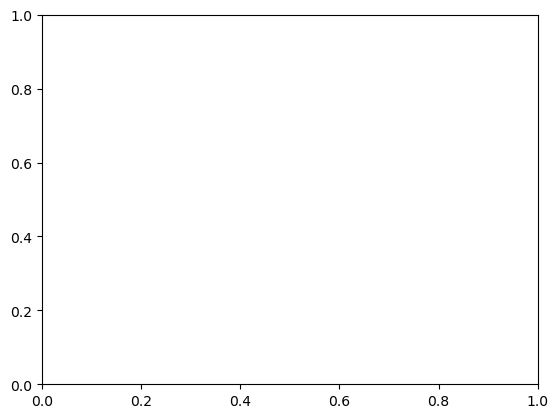

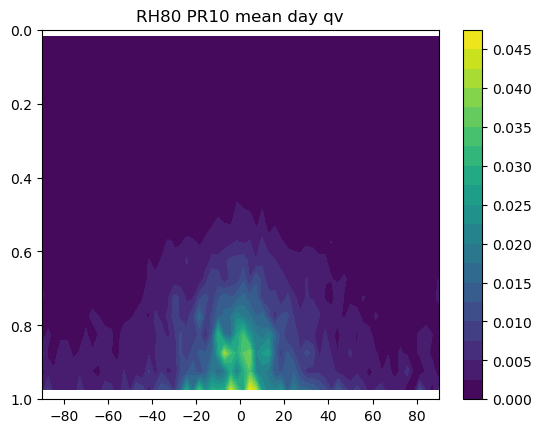

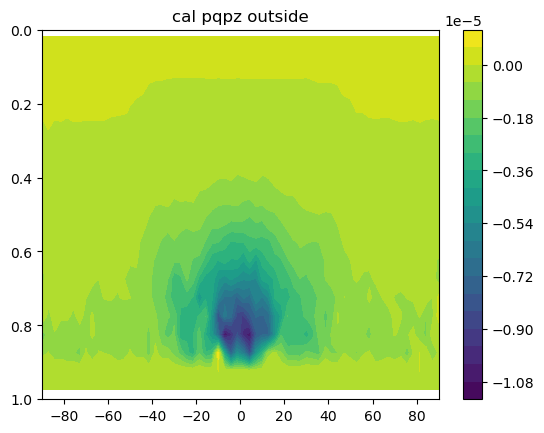

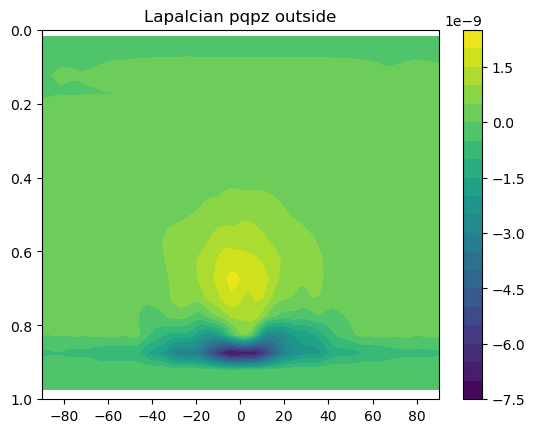

In [ ]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_n = dycore.qv_n


    plt.figure(dpi=100.)
    qv_mean = np.nanmean(qv[4:5,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, qv_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} mean day qv")

    plt.ylim([1,0])
    plt.show()

pqpz_new = np.zeros((((5,20,64,128))))
z = dycore.z
for i in range(1,18):
    pqpz_new[:,i,:,:] = (qv_n[:,i+1,:,:] - qv_n[:,i-1,:,:]) / (z[:,i+1,:,:] - z[:,i-1,:,:])
# pqpz_new[:,1,:,:] = (qv_n[:,1,:,:] - qv_n[:,0,:,:]) / (z[:,1,:,:] - z[:,0,:,:])
# pqpz_new[:,19,:,:] = (qv_n[:,19,:,:] - qv_n[:,18,:,:]) / (z[:,19,:,:] - z[:,18,:,:])

plt.figure(dpi=100.)
plt.contourf(yy, sigma_mean2, np.nanmean(pqpz_new[:,:,:,:,], axis=(0,3)), levels=21)
plt.colorbar()
plt.ylim([1,0])
plt.title("cal pqpz outside")
plt.show()

###################################################################################
ppqpzpz = np.zeros((((5,20,64,128))))
for i in range(1,18):
    ppqpzpz[:,i,:,:] = (pqpz_new[:,i+1,:,:] - pqpz_new[:,i-1,:,:]) / (z[:,i+1,:,:] - z[:,i-1,:,:]) 

plt.figure(dpi=100.)
plt.contourf(yy, sigma_mean2, np.nanmean(ppqpzpz[:1,:,:,:,], axis=(0,3)), levels=21)
plt.colorbar()
plt.ylim([1,0])
plt.title("Lapalcian pqpz outside")
plt.show()

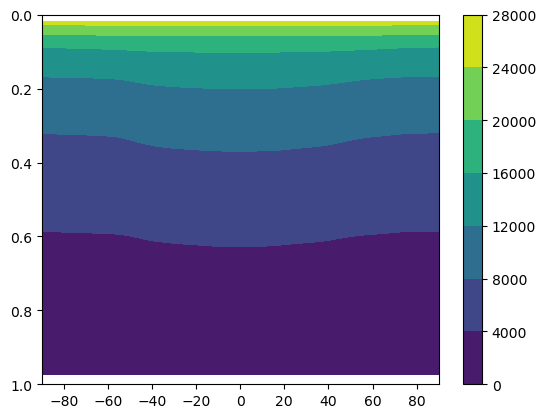

In [ ]:
np.shape(z)
plt.figure()
cs=plt.contourf(yy,sigma_mean2,z[0,:,:,:].mean(axis=2))
plt.colorbar(cs)
plt.ylim([1,0])
plt.show()

(5, 20, 64, 128)


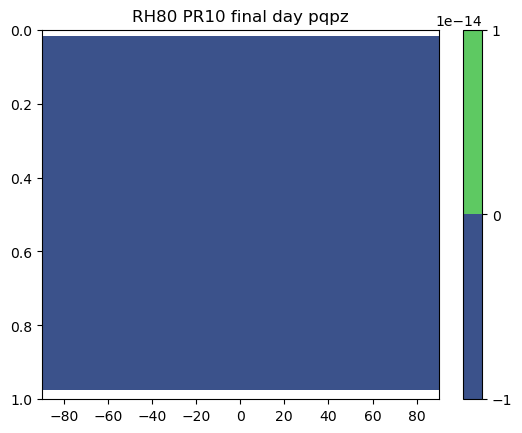

In [ ]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    pqpz = dycore.pqpz
    print(pqpz.shape)
    plt.figure(dpi=100.)
    pqpz_mean = np.nanmean(pqpz[0:1,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, pqpz_mean, levels=21) #np.linspace(-9E-6, 9E-6,21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} final day pqpz")

    plt.ylim([1,0])
    plt.show()


# Others

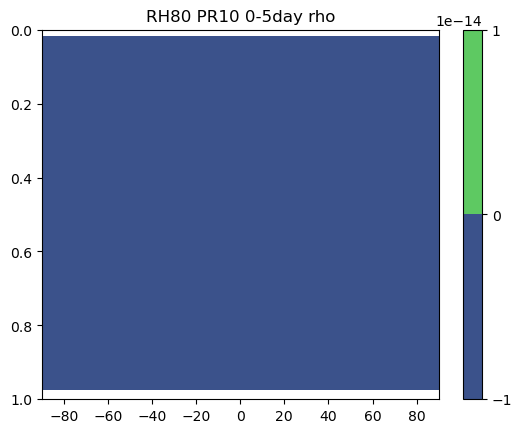

In [ ]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    rho = dycore.rho

    plt.figure(dpi=100.)
    rho_mean = np.nanmean(rho[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, rho_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day rho")

    plt.ylim([1,0])
    plt.show()


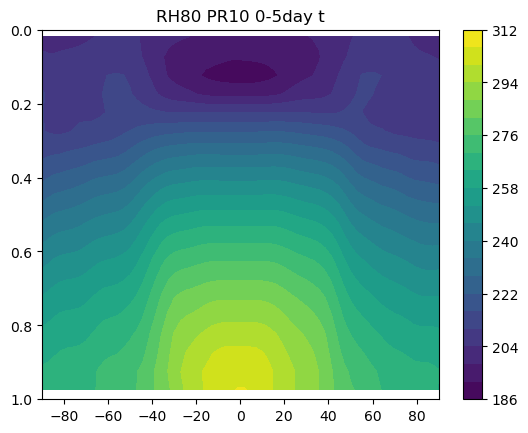

In [ ]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    t = dycore.t

    plt.figure(dpi=100.)
    t_mean = np.nanmean(t[-1:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, t_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day t")

    plt.ylim([1,0])
    plt.show()

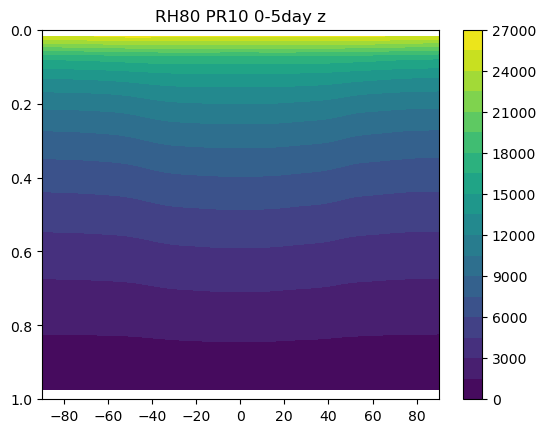

In [ ]:

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    z = dycore.z

    plt.figure(dpi=100.)
    z_mean = np.nanmean(z[:,:,:,:], axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, z_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day z")

    plt.ylim([1,0])
    plt.show()


# pring grid_tracers_n and c

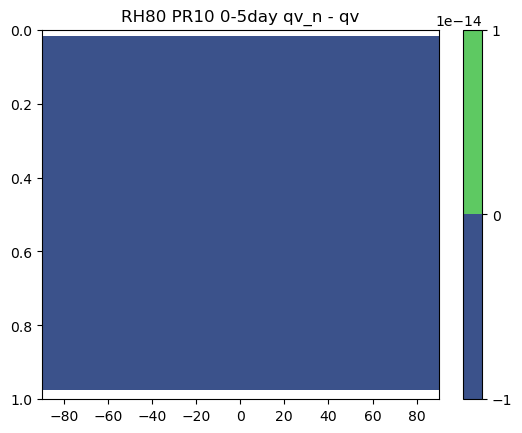

0.0


In [ ]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv_n = dycore.qv_n
    qv_p = dycore.qv_p
    qv   = dycore.qv

    plt.figure(dpi=100.)
    qv_n_mean = np.nanmean(qv_n[:,:,:,:], axis=(0,3))
    qv_p_mean = np.nanmean(qv_p[:,:,:,:], axis=(0,3))

    qv_mean = np.nanmean(qv[:,:,:,:], axis=(0,3))


    CS = plt.contourf(yy, sigma_mean2, qv_mean - qv_n_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day qv_n - qv")

    plt.ylim([1,0])
    plt.show()
print(np.max(qv_n_mean - qv_mean))

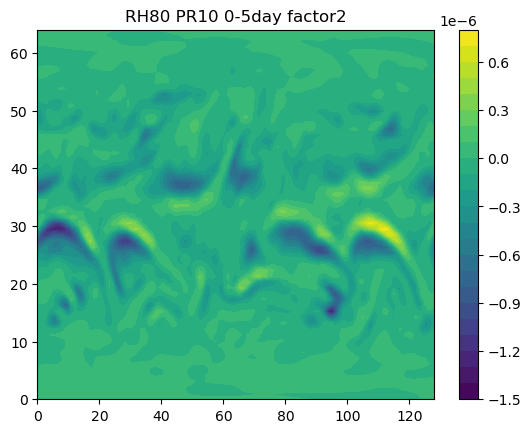

(64, 128)


In [ ]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    factor2 = dycore.factor2

    plt.figure(dpi=100.)
    factor2_mean = np.nanmean(factor2[3:4,-1,:,:], axis=(0))
    x = np.linspace(0,128,128)
    y = np.linspace(0,64,64)
    xx, yy = np.meshgrid(x,y)
    CS = plt.contourf(xx, yy ,factor2_mean, levels=21)
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 0-5day factor2")

    #plt.ylim([1,0])

    plt.show(CS)
print(np.shape(factor2_mean))

In [ ]:
np.max(ps[:,0,:,:] - p[:,19,:,:])
# print(np.shape(p))
# print(np.nanmean(p[:,19,:,:]))

2568.534569683514

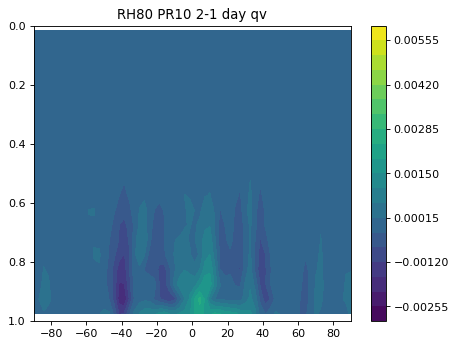

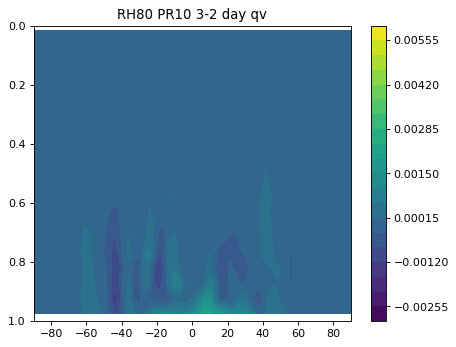

In [ ]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_n = dycore.qv_n


    plt.figure(dpi=80.)
    qv_mean1 = np.nanmean(qv[1:2,:,:,:], axis=(0,3))
    qv_mean2 = np.nanmean(qv[2:3,:,:,:], axis=(0,3))


    CS = plt.contourf(yy, sigma_mean2, (qv_mean2 - qv_mean1), levels=np.linspace(-0.003, 0.006,21))
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 2-1 day qv")

    plt.ylim([1,0])
    plt.show()

for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_n = dycore.qv_n


    plt.figure(dpi=80.)
    qv_mean3 = np.nanmean(qv[3:4,:,:,:], axis=(0,3))


    CS = plt.contourf(yy, sigma_mean2, (qv_mean3 - qv_mean2), levels=np.linspace(-0.003, 0.006,21))
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 3-2 day qv")

    plt.ylim([1,0])
    plt.show()

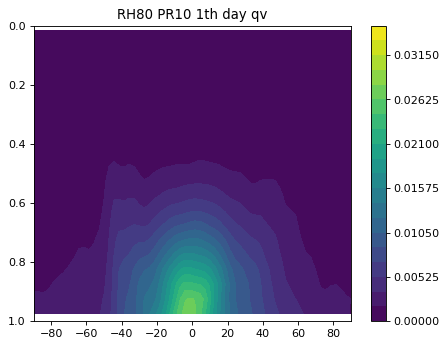

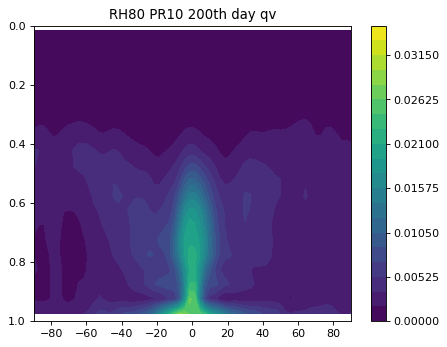

In [9]:
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_n = dycore.qv_n


    plt.figure(dpi=80.)
    qv_mean1 = np.nanmean(qv[0,:,:,:], axis=(2))
    # qv_mean2 = np.nanmean(qv[2,:,:,:], axis=(0,3))


    CS = plt.contourf(yy, sigma_mean2, (qv_mean1), levels=np.linspace(0,0.035,21))
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 1th day qv")

    plt.ylim([1,0])
    plt.show()
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    qv = dycore.qv
    qv_n = dycore.qv_n


    plt.figure(dpi=80.)
    qv_mean1 = np.nanmean(qv[-1,:,:,:], axis=(2))
    # qv_mean2 = np.nanmean(qv[2,:,:,:], axis=(0,3))


    CS = plt.contourf(yy, sigma_mean2, (qv_mean1), levels=np.linspace(0,0.035,21))
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day qv")

    plt.ylim([1,0])
    plt.show()


In [ ]:
np.nanmax(np.nanmean(z[:,19,:,:], axis=1))


212.99703444489484

In [ ]:
np.nanmax(np.nanmean(z[:,19,:,:], axis=1))
tv = t[:,19,:,:] * (1+0.608*qv[:,19,:,:])
za = 287 * tv/9.81 * (np.log(ps[:,0,:,:]) - np.log(p[:,19,:,:])) /2
print(np.nanmax(za))
print(np.nanmin(za))

print(np.nanmin(tv))
print(np.nanmin(np.log(ps[:,0,:,:])))



137.9371352074981
97.33547225575153
261.68942822781975
11.458354372162727


In [ ]:

rho = dycore.rho
qv   = dycore.qv
t = dycore.t
Lv = 2.5E6
Rv = 461
p = dycore.p
qvs = (0.622 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / t)) )) / (p - 0.378 * (611.12 * np.exp(Lv / Rv * (1. / 273.15 - 1. / t)) )) 
print(np.shape())
# K_E[0,].min()
print(np.shape(factor1))
plt.figure()
plt.contourf(qvs.mean(axis=(0,3)))
# plt.title("qv_new")
plt.ylim([20,0])
plt.show()


TypeError: shape() missing 1 required positional argument: 'a'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt



# raw         = qv[0,] * K_E[0,]

# (lev, lat, lon) = (20, 64, 128)
def fourier(x, number_of_harmonics):
    dim1         = np.shape(x)[0] 
    x            = np.reshape(x, ((int(dim1), int(np.size(x)/dim1))))                  # pressure, space
    time_series  = np.zeros((dim1,number_of_harmonics))            # 20 X 10
    time_series2 = np.zeros((dim1+2,number_of_harmonics))           # 20 X 10
    wn           = np.zeros((number_of_harmonics,number_of_harmonics)) ############

    # print(np.shape(time_series))
    for i in range(0,number_of_harmonics):
        wn[i,i]              = (2*i*np.pi/dim1)
        time_series[:,i]     = np.arange(0,dim1) * (2*i*np.pi/dim1) # time_series = omega = 2 pi t / T original: *(2*i*np.pi/dim1)
        time_series2[1:-1,i] = np.arange(0,dim1) * (2*i*np.pi/dim1) # time_series = omega = 2 pi t / T original: *(2*i*np.pi/dim1)
        time_series2[0,i]    = 0 - (2*np.pi/dim1)
        time_series2[-1,i]   = 2*np.pi+(2*np.pi/dim1)   
    cos_coef    = np.matmul(np.transpose(np.cos(time_series)),x)/len(x)*2  # [20X10]^T [20X64X128] = [10X64X128] 
    sin_coef    = np.matmul(np.transpose(np.sin(time_series)),x)/len(x)*2  

    
    reconstruct  = (np.matmul(np.cos(time_series),cos_coef)+np.matmul(np.sin(time_series),sin_coef)) /dim1*2 # [20X10] X [10X64X128]
    reconstruct2 = (np.matmul(np.cos(time_series2),cos_coef)+np.matmul(np.sin(time_series2),sin_coef)) /dim1*2 # [20X10] X [10X64X128]
    # print(np.shape(wn))
    # print(np.shape(cos_coef))
    
    dv_sin = (np.matmul(wn, cos_coef))
    dv_cos = (np.matmul(wn, sin_coef))
    reconstruct_dv  = (-np.matmul(np.sin(time_series),dv_sin)+np.matmul(np.cos(time_series),dv_cos)) /dim1*2
    reconstruct_dv2 = (-np.matmul(np.sin(time_series2),dv_sin)+np.matmul(np.cos(time_series2),dv_cos)) /dim1*2

    # print(np.shape(dv))
    return cos_coef,sin_coef,reconstruct,reconstruct2, reconstruct_dv,reconstruct_dv2

qv_new = np.zeros(((22,64,128)))
# qv_new[1:21,] = qv[0,0:20,:,:]
qv_new[-1,]   = factor1[0,-1,:,:]
qv_new[0,]    = 0.
qv_new[1:21,] = qv[0,0:20,:,:]

print(np.shape(qv_new))

A_k,B_k,reconstruct,reconstruct2,  reconstruct_dv, reconstruct_dv2    = fourier(qv_new[:,:,:],10000) # *K_E[0,:,:,:]*-rho[0,:,:,:]*9.81
reconstruct                             = np.reshape(reconstruct,[20+2,64,128])
print(np.shape(reconstruct_dv))
reconstruct_dv                          = np.reshape(reconstruct_dv,[20+2,64,128])
# reconstruct_dv[0,:,:] = 0.
reconstruct2                            = np.reshape(reconstruct2,[22+2,64,128])

# reconstruct_dv[-1,:] = 0.

A_k,B_k,reconstruct_2,reconstruct2_2,  reconstruct_dv_2, reconstruct_dv_3   = fourier(reconstruct_dv[:,:,:],10000)
reconstruct_dv_2                        = np.reshape(reconstruct_dv_2,[20+2,64,128])


#print(np.shape(A_k))
plt.figure()
plt.contourf(qv_new.mean(axis=2))
plt.title("qv_new")
plt.ylim([22,0])
plt.show()

plt.figure()
plt.contourf(yy, sigma_mean2,qv[0,].mean(axis=2))
plt.title("original qv")
plt.ylim([1,0])
plt.show()

plt.figure()
CS = plt.contourf(reconstruct[:,:,:].mean(axis=2))
plt.colorbar(CS)
plt.title("reconstruct qv")
plt.ylim([20,0])
plt.show()

plt.figure()
plt.contourf(reconstruct2[1:-1,].mean(axis=2))
plt.title("reconstruct2 qv (which mean shift idx)")
plt.colorbar()
plt.ylim([20,0])
plt.show()


plt.figure()
CS = plt.contourf((reconstruct_dv[:,:,:]).mean(axis=2), levels=11)
plt.colorbar(CS)
plt.title("dqv/dz qv (which mean shift idx)")
plt.ylim([22,0])
plt.show()


plt.figure()
CS2 = plt.contourf((reconstruct_dv_2[:]).mean(axis=2), levels=11)
plt.colorbar(CS2)
plt.title("d^2qv/dz^2 qv (which mean shift idx)")
plt.ylim([22,0])
plt.show()








In [ ]:
np.shape(reconstruct_dv)

In [ ]:
### 
# factor1
under = dv2[19,:,:]
for i in range(20):
    dv2[i,:,:] /= under 
    dv2[i,:,:] *= factor1[0,19,:]


In [ ]:
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(5,15))
CS1 = ax[0].contourf(reconstruct.mean(axis=2))
ax[0].set_title("Reconstruct: qv")
ax[0].set_ylim([20,0])
fig.colorbar(CS1, orientation='vertical',fraction=0.046, pad=0.04)


CS2 = ax[1].contourf((qv[0,]).mean(axis=2))
ax[1].set_title("Original data: qv ")
ax[1].set_ylim([20,0])
fig.colorbar(CS2, orientation='vertical',fraction=0.046, pad=0.04)

#############################################################################
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(5,15))
CS1 = ax[0].contourf(reconstruct2.mean(axis=2))
ax[0].set_title("Reconstruct: dqdp")
ax[0].set_ylim([20,0])
fig.colorbar(CS1, orientation='vertical',fraction=0.046, pad=0.04)


# CS2 = ax[1].contourf((pqpz[0,]).mean(axis=2))
# ax[1].set_title("Original data: dqdp")
# ax[1].set_ylim([20,0])
# fig.colorbar(CS2, orientation='vertical',fraction=0.046, pad=0.04)
#############################################################################

CS3 = ax[2].contourf((dv2).mean(axis=2))
ax[2].set_ylim([20,0])
ax[2].set_title("wavenumber * (sin_coef + cos_coef): qv * Ke")
# plt.colorbar(CS3)
fig.colorbar(CS3, orientation='vertical',fraction=0.046, pad=0.04)

plt.show()
for i in range(10,20,10):
    pr = i
    dycore = Dycore(file)
    yy, sigma_mean2 = dycore.yy, dycore.sigma_mean2

    plt.figure(dpi=100.)
    factor3 = dycore.getVar("factor3_xyzt")
    factor_mean = np.nanmean(factor1 + factor2 , axis=(0,3))

    CS = plt.contourf(yy, sigma_mean2, factor_mean, levels=21) #, cmap="BrBG"
    # plt.contour(yy, sigma_mean2, factor_mean, [-0.0005,0], color='k')
    plt.colorbar(CS)
    plt.title(f"RH80 PR{pr} 200th day factor_all")

    plt.ylim([1,0])
    plt.show()


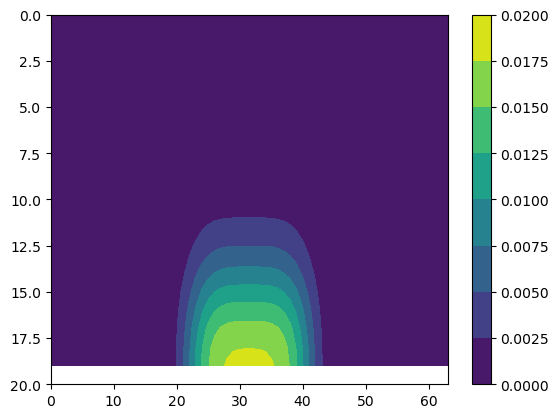

In [ ]:
q0 = 18E-3
phi = np.linspace(-90,90,64)
p_hw = 30000
ps = 100000
p  = np.linspace(1,100000,20)
phi_hw = 2 * np.pi /9 * np.deg2rad(40)
p0 = 100000

qv_try = np.zeros((20,64))
for i in range(20):
    for j in range(64): 
        qv_try[i,j] = q0 * np.exp(-(np.deg2rad(phi[j])/phi_hw)**4) * np.exp(-((p[i]/ps - 1)*(p0/p_hw))**2)
plt.figure()
CS = plt.contourf(qv_try)
plt.colorbar(CS)
plt.ylim([20,0])
plt.show()


In [ ]:
p = dycore.p
np.nanmean(p[:,2,:,:])